<a href="https://colab.research.google.com/github/sophieellwood/Variational-Autoender-with-Signed-Distance-Functions-SDFs-in-Jax/blob/main/VAE_DeepSDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational autoender with Signed Distance Functions (SDFs) in Jax**

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/autoencoder_visualization.svg?raw=1" style="display: block; margin-left: auto; margin-right: auto;" width="650px"/></center>

In [105]:
## Standard libraries
import os
import json
import math
import numpy as np
from scipy import spatial
from flax import nnx

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import CIFAR10

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial9_jax"
CHECKPOINT_PATH = os.path.abspath(CHECKPOINT_PATH)

print("Device:", jax.devices()[0])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0


/tmp/ipython-input-3345988740.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [106]:
print(jax.devices())

[CudaDevice(id=0)]


## Get the SDF data

In [107]:
from torchvision import transforms
import scipy.ndimage
from torch.utils.data import Subset


class SignedDistanceTransform:
    def __call__(self, img_tensor):
        # Threshold.
        img_tensor[img_tensor<0.5] = 0.
        img_tensor[img_tensor>=0.5] = 1.

        # Compute signed distances with distance transform
        img_tensor = img_tensor.numpy()

        neg_distances = scipy.ndimage.morphology.distance_transform_edt(img_tensor)
        sd_img = img_tensor - 1.
        sd_img = sd_img.astype(np.uint8)
        signed_distances = scipy.ndimage.morphology.distance_transform_edt(sd_img) - neg_distances
        signed_distances /= float(img_tensor.shape[1])
        signed_distances = torch.Tensor(signed_distances)

        return signed_distances, torch.Tensor(img_tensor)

def get_mgrid(sidelen):
    # Generate 2D pixel coordinates from an image of sidelen x sidelen
    pixel_coords = np.stack(np.mgrid[:sidelen,:sidelen], axis=-1)[None,...].astype(np.float32)
    pixel_coords /= sidelen
    pixel_coords -= 0.5
    pixel_coords = torch.Tensor(pixel_coords).view(-1, 2)
    return pixel_coords

class MNISTSDFDataset(torch.utils.data.Dataset):
    def __init__(self, split, size=(256,256)):
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            SignedDistanceTransform(),
        ])
        self.img_dataset = torchvision.datasets.MNIST('./datasets/MNIST', train=True if split == 'train' else False,
                                                download=True)
        self.meshgrid = get_mgrid(size[0])
        self.im_size = size

    def __len__(self):
        return len(self.img_dataset)

    def __getitem__(self, item):
        img, digit_class = self.img_dataset[item]

        signed_distance_img, binary_image = self.transform(img)

        coord_values = self.meshgrid.reshape(-1, 2)
        signed_distance_values = signed_distance_img
        signed_distance_values = signed_distance_img.reshape((-1, 1))
        image_values = binary_image.reshape((-1, 1))
        side_len = int(np.sqrt(coord_values.shape[0]))
        image_values_reshaped = binary_image.reshape(side_len, side_len, 1)
        indices = torch.randperm(coord_values.shape[0])
        support_indices = indices[:indices.shape[0]//2]
        query_indices = indices[indices.shape[0]//2:]

        meta_dict = {'images': (coord_values, image_values_reshaped), 'context': (coord_values[support_indices], signed_distance_values[support_indices]), 'query': (coord_values[query_indices], signed_distance_values[query_indices]), 'all': (coord_values, signed_distance_values, image_values_reshaped)}

        return meta_dict

## Set up dataloaders

In [108]:
train_dataset = MNISTSDFDataset('train', size=(28, 28))
val_dataset = MNISTSDFDataset('val', size=(28, 28))
test_dataset = MNISTSDFDataset('test', size=(28, 28))

train_subset = Subset(train_dataset, list(range(1000)))
val_subset = Subset(val_dataset, list(range(1000)))
test_subset = Subset(test_dataset, list(range(1000)))

train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=16)
val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=16)
test_dataloader = torch.utils.data.DataLoader(test_subset, batch_size=16)

In [109]:
batch = next(iter(train_dataloader))
coord_values, sdf_values, image_values = batch['all']
image_values = (image_values).cpu().numpy()
image_values.shape

/tmp/ipython-input-1334695404.py:15: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  neg_distances = scipy.ndimage.morphology.distance_transform_edt(img_tensor)
/tmp/ipython-input-1334695404.py:18: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  signed_distances = scipy.ndimage.morphology.distance_transform_edt(sd_img) - neg_distances


(16, 28, 28, 1)

## Set up the Encoder, Decoder and VAE classes

In [110]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx

class Encoder(nnx.Module):
    def __init__(self, input_size: int, c_hid: int, latent_dim: int, *, rngs: nnx.Rngs):
        self.c_hid = c_hid
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.rngs = rngs

        # Define layers
        self.conv1 = nnx.Conv(in_features=1, out_features=c_hid, kernel_size=(3, 3), strides=2, rngs=rngs, padding="SAME")
        self.conv2 = nnx.Conv(in_features=c_hid, out_features=c_hid, kernel_size=(3, 3), rngs=rngs, padding="SAME")
        self.conv3 = nnx.Conv(in_features=c_hid, out_features=2*c_hid, kernel_size=(3, 3), strides=2, rngs=rngs, padding="SAME")
        self.conv4 = nnx.Conv(in_features=2*c_hid, out_features=2*c_hid, kernel_size=(3, 3), rngs=rngs,  padding="SAME")
        self.conv5 = nnx.Conv(in_features=2*c_hid, out_features=2*c_hid, kernel_size=(3, 3), strides=2, rngs=rngs,  padding="SAME")

        self.fc_mean = nnx.Linear(rngs=rngs, in_features=1024, out_features=latent_dim)
        self.fc_logvar = nnx.Linear(rngs=rngs, in_features=1024, out_features=latent_dim)

    def __call__(self, x: jax.Array, *, deterministic: bool = False, key: jax.Array | None = None):
        x = nnx.gelu(self.conv1(x))
        x = nnx.gelu(self.conv2(x))
        x = nnx.gelu(self.conv3(x))
        x = nnx.gelu(self.conv4(x))
        x = nnx.gelu(self.conv5(x))

        x = x.reshape(x.shape[0], -1)  # flatten
        mean = self.fc_mean(x)
        logvar = jnp.clip(self.fc_logvar(x), -10, 10)
        std = jnp.exp(0.5 * logvar)

        if deterministic:
            z = mean
        else:
            z = mean + std * jax.random.normal(self.rngs.noise(), mean.shape)

        return z, mean, std


In [111]:
class Decoder(nnx.Module):
  def __init__(self, input_size: int, intermediate_size: int, output_size: int,
               *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(input_size, intermediate_size, rngs=rngs)
    self.linear2 = nnx.Linear(intermediate_size, intermediate_size, rngs=rngs)
    self.linear2 = nnx.Linear(intermediate_size, intermediate_size, rngs=rngs)
    self.linear2 = nnx.Linear(intermediate_size, output_size, rngs=rngs)

  def __call__(self, z: jax.Array) -> jax.Array:
    z = self.linear1(z)
    z = jax.nn.relu(z)
    logits = self.linear2(z)
    return logits

DeepSDF Decoder takes in a 2D coordinate + the latent vector learned from the encoder. This is different to the vanilla encoder above which just uses a latent. Currently, this is not working super well for reconstruction, the learned SDF values don't span the range -1 -> 1. A normal decoder is used to show the possibilities for sampling in latent space.

In [112]:
# from typing import Sequence, Optional, Tuple
# import jax
# import jax.numpy as jnp
# import flax.nnx as nnx

# class Decoder(nnx.Module):
#     latent_size: int
#     dims: Sequence[int]
#     dropout: Optional[Sequence[int]] = None
#     dropout_prob: float = 0.0
#     norm_layers: Tuple[int, ...] = ()
#     latent_in: Tuple[int, ...] = ()
#     xy_in_all: bool = False
#     use_tanh: bool = False
#     latent_dropout: bool = False

#     def __init__(self,
#                  latent_size: int,
#                  dims: Sequence[int],
#                  *,
#                  rngs: nnx.Rngs,
#                  dropout: Optional[Sequence[int]] = None,
#                  dropout_prob: float = 0.0,
#                  norm_layers: Tuple[int, ...] = (),
#                  latent_in: Tuple[int, ...] = (),
#                  xy_in_all: bool = False,
#                  use_tanh: bool = False,
#                  latent_dropout: bool = False):
#         self.latent_size = latent_size
#         self.dims = list(dims)
#         self.dropout = dropout or []
#         self.dropout_prob = dropout_prob
#         self.norm_layers = norm_layers
#         self.latent_in = latent_in
#         self.xy_in_all = xy_in_all
#         self.use_tanh = use_tanh
#         self.latent_dropout = latent_dropout
#         self.rngs = rngs

#     def __call__(self, inputs: jax.Array, *, deterministic: bool = True):
#         x = inputs
#         xy = inputs[..., -2:]

#         if self.latent_dropout and inputs.shape[-1] > 2:
#             latent_vecs = inputs[..., :-2]
#             latent_vecs = nnx.Dropout(rate=0.2)(latent_vecs, deterministic=deterministic)
#             x = jnp.concatenate([latent_vecs, xy], axis=-1)

#         dims = [self.latent_size + 2] + list(self.dims) + [1]
#         num_layers = len(dims) - 1

#         for layer in range(num_layers):
#             if layer + 1 in self.latent_in:
#                 out_dim = dims[layer + 1] - dims[0]
#             else:
#                 out_dim = dims[layer + 1]
#                 if self.xy_in_all and layer != num_layers - 1:
#                     out_dim -= 2

#             if layer in self.latent_in:
#                 x = jnp.concatenate([x, inputs], axis=-1)
#             elif layer != 0 and self.xy_in_all:
#                 x = jnp.concatenate([x, xy], axis=-1)

#             # Linear
#             x = nnx.Linear(x.shape[-1], out_dim, rngs=self.rngs)(x)

#             # Hidden layers only
#             if layer < num_layers - 1:
#                 if layer in self.norm_layers:
#                     x = nnx.LayerNorm(x.shape[-1], rngs=self.rngs)(x)
#                 if layer < num_layers - 2:
#                     x = nnx.relu(x)
#                 if self.dropout and layer in self.dropout:
#                     x = nnx.Dropout(rate=self.dropout_prob)(x, deterministic=deterministic)

#         # x = jnp.tanh(x)
#         return x  # shape (B, N, 1)


In [113]:
class VAE(nnx.Module):
  def __init__(
    self,
    image_shape: tuple[int, int],
    hidden_size: int,
    latent_size: int,
    *,
    rngs: nnx.Rngs
  ):
    self.image_shape = image_shape
    self.latent_size = latent_size
    input_size = image_shape[0] * image_shape[1]
    self.encoder = Encoder(input_size, hidden_size, latent_size, rngs=rngs)
    self.decoder = Decoder(latent_size, hidden_size, input_size, rngs=rngs)
    # self.decoder = Decoder(
    # latent_size=latent_size,
    # dims=[512, 512, 256],
    # rngs=rngs,
    # dropout=[1],
    # dropout_prob=0.1,
    # norm_layers=(1,),
    # xy_in_all=True,
    # )
  def __call__(self, x: jax.Array,  coords: jax.Array, *, deterministic: bool = False, key: jax.Array | None = None):

    x = x.reshape(-1, 28, 28, 1)
    z, mean, std = self.encoder(x, deterministic=deterministic, key=key)
    z_hat = prepare_decoder_inputs(z, coords)
    logits = self.decoder(z)  # or z_hat if deepsf


    logits = jnp.reshape(logits, (-1, *self.image_shape))
    return logits[...,None], mean, std

In [114]:
import optax
@nnx.jit
def train_step(model: VAE, optimizer: nnx.Optimizer, x: jax.Array, coords: jax.Array):
  loss, grads = nnx.value_and_grad(vae_loss)(model, x, coords)
  optimizer = optimizer.update(grads)
  return loss

In [115]:
def prepare_decoder_inputs(latent_vectors, coords):
    B, N, _ = coords.shape
    latent_expanded = jnp.expand_dims(latent_vectors, axis=1)  # (B,1,latent_dim)
    latent_expanded = jnp.repeat(latent_expanded, N, axis=1)  # (B, N, latent_dim)
    decoder_inputs = jnp.concatenate([latent_expanded, coords], axis=-1)  # (B, N, latent_dim+coord_dim)
    return decoder_inputs

In [116]:
from jax import random, jit, vmap, lax, grad, value_and_grad
@vmap
def log_lik(x, x_reconstructed):
  var = 1
  x = x.flatten()
  x_reconstructed = x_reconstructed.flatten()
  diff = x-x_reconstructed
  return -(1/var)*jnp.dot(diff, diff)

@vmap
def kl_divergence(mean, logstd):
  return -0.5*jnp.sum(1 + 2*logstd - jnp.square(jnp.exp(logstd)) - jnp.square(mean))


Training on the normalized SDF values

In [119]:
def vae_loss(model: VAE, x: jax.Array,coords: jax.Array ):
  logits, mean, std = model(x, coords)
  kl_loss = jnp.mean(0.5 * jnp.mean(
      -jnp.log(std ** 2) - 1.0 + std ** 2 + mean ** 2, axis=-1))
  # reconstruction_loss = jnp.mean(
  #   optax.sigmoid_binary_cross_entropy(logits, x)
  # )
  # reconstruction_loss = jnp.mean((logits - x.reshape(-1, 28, 28, 1)) ** 2)  # use MSE
  reconstruction_loss = - log_lik(x, logits).mean() + kl_divergence(mean, std).mean()
  return reconstruction_loss +  kl_loss

model = VAE(
  image_shape=(28, 28),
  hidden_size=32,
  latent_size=256,
  rngs=nnx.Rngs(0, noise=1),
)
dim_latent=256

sdf_values= sdf_values.cpu().numpy()
coord_values = coord_values.cpu().numpy()
sdf_min = jnp.min(sdf_values, axis=1, keepdims=True)   # (B,1)
sdf_max = jnp.max(sdf_values, axis=1, keepdims=True)   # (B,1)

# scale to [-1,1]
sdf_norm = 2 * (sdf_values - sdf_min) / (sdf_max - sdf_min + 1e-8) - 1

optimizer = nnx.Optimizer(model, optax.adam(1e-3))
for epoch in range(2001):
  loss = train_step(model, optimizer, sdf_norm, coord_values)
  if epoch % 500 == 0:
    print(f'Epoch {epoch} loss: {loss}')

Epoch 0 loss: 1209.0931396484375
Epoch 500 loss: 15.71680736541748
Epoch 1000 loss: 9.464699745178223
Epoch 1500 loss: 6.751689910888672
Epoch 2000 loss: 5.6453351974487305


## Evaluate on test set

In [120]:
batch = next(iter(test_dataloader))
coord_values_test, sdf_values_test, image_values_test = batch['all']
sdf_values_test = sdf_values_test.cpu().numpy()
coord_values_test = coord_values_test.cpu().numpy()
sdf_min_test = jnp.min(sdf_values_test, axis=1, keepdims=True)   # (B,1)
sdf_max_test = jnp.max(sdf_values_test, axis=1, keepdims=True)   # (B,1)

# scale to [-1,1]
sdf_norm_test = 2 * (sdf_values_test - sdf_min_test) / (sdf_max_test - sdf_min_test + 1e-8) - 1
logits, mean, std = model(sdf_norm_test, coord_values_test)
images_pred = jax.nn.sigmoid(logits)

/tmp/ipython-input-1334695404.py:15: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  neg_distances = scipy.ndimage.morphology.distance_transform_edt(img_tensor)
/tmp/ipython-input-1334695404.py:18: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  signed_distances = scipy.ndimage.morphology.distance_transform_edt(sd_img) - neg_distances


In [121]:
print("Mean:", mean.mean())
print("Std", std.std())
print("SDF min and max:", sdf_norm.min(), sdf_norm.max())
print("Learned SDF min and max:", logits.min(), logits.max())

Mean: 0.0051776823
Std 0.0042411895
SDF min and max: -1.0 1.0
Learned SDF min and max: -1.061421 1.0902979


## Checking reconstruction

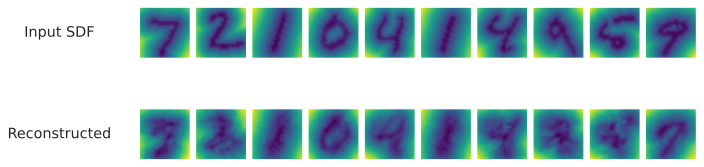

In [122]:
fig, ax = plt.subplots(2, 10, figsize=(10, 3.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):

  ax[0, i].imshow(sdf_norm_test.reshape(-1, 28, 28, 1)[i], cmap='viridis', interpolation='gaussian')
  ax[1, i].imshow(images_pred[i], cmap='viridis', interpolation='gaussian')
  ax[0, 0].set_ylabel("Input SDF", rotation=0, size='large', labelpad=80, va='center')
  ax[1, 0].set_ylabel("Reconstructed", rotation=0, size='large', labelpad=80, va='center')

## Generating new images from sampling in latent space

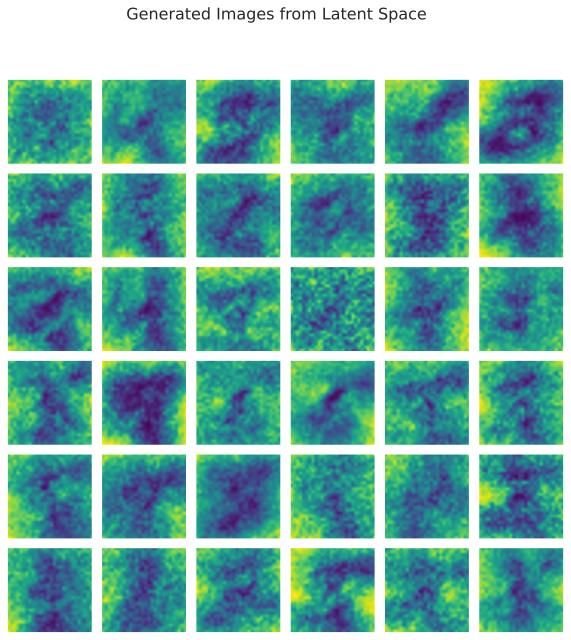

In [123]:
import numpy as np

# generate new images by sampling the latent space
z = np.random.normal(scale=1, size=(36, model.latent_size))
logits = model.decoder(z).reshape(-1, 28, 28)
images_gen = nnx.sigmoid(logits)

fig, ax = plt.subplots(6, 6, figsize=(10, 10),  # bigger figure
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(36):
  ax.flat[i].imshow(images_gen[i], cmap='viridis', interpolation='gaussian')
fig.suptitle("Generated Images from Latent Space", fontsize=16)
print()

## Interpolation in latent space

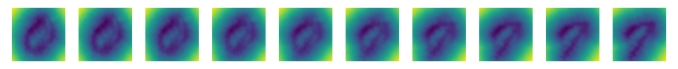

In [124]:
z, _, _ = model.encoder(sdf_norm_test.reshape(-1, 28, 28, 1))
# img = z[3]
zrange = jnp.linspace(z[3], z[9], 10)

logits = model.decoder(zrange).reshape(-1, 28, 28, 1)
images_gen = nnx.sigmoid(logits)

fig, ax = plt.subplots(1, 10, figsize=(12, 1),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
  ax.flat[i].imshow(images_gen[i], cmap='viridis', interpolation='gaussian')


# **Vanilla Autoencoder**



<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/deconvolution.gif?raw=1" width="250px"></center>



In [ ]:
class GenerateCallback:

    def __init__(self, input_imgs, coords, rng, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        self.coords = coords
        self.every_n_epochs = every_n_epochs  # Only save those images every N epochs (otherwise tensorboard gets quite large)
        self.rng_noise, self.rng_dropout = jax.random.split(rng, 2)

    def log_generations(self, model, state, logger, epoch):
        if epoch % self.every_n_epochs == 0:
            reconst_sdf, mu, std = model.apply({'params': state.params}, self.input_imgs.cpu().numpy(), self.coords.cpu().numpy(), rngs={'noise': self.rng_noise, 'dropout': self.rng_dropout}, deterministic=True)
            reconst_imgs = np.array(reconst_imgs)
            # # Plot and add to tensorboard
            # imgs = np.stack([self.input_imgs, reconst_imgs], axis=1).reshape(-1, *self.input_imgs.shape[1:])
            # imgs = jax_to_torch(imgs)
            # grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, value_range=(-1,1))
            # logger.add_image("Reconstructions", grid, global_step=epoch)

In [ ]:
class VanillaEncoder(nn.Module):
    c_hid : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 32x32 => 16x16
        x = nn.gelu(x)
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 16x16 => 8x8
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 8x8 => 4x4
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], -1)  # Image grid to single feature vector
        x = nn.Dense(features=self.latent_dim)(x)
        return x

In [ ]:
from typing import Sequence, Optional, Tuple
# LIPSCHITZ REGULARIZATION ADDED TO DECODER

class Decoder(nn.Module):
    latent_size: int
    dims: Sequence[int]
    dropout: Optional[Sequence[int]] = None
    dropout_prob: float = 0.0
    norm_layers: Tuple[int, ...] = ()
    latent_in: Tuple[int, ...] = ()
    xy_in_all: bool = False
    use_tanh: bool = False
    latent_dropout: bool = False

    @nn.compact
    def __call__(self, inputs, *, deterministic: bool):
        # inputs: (B, N, latent_size + 2)
        x = inputs
        xy = inputs[..., -2:]  # (B, N, 2)

        if inputs.shape[-1] > 2 and self.latent_dropout:
            latent_vecs = inputs[..., :-2]  # (B, N, latent_size)
            latent_vecs = nn.Dropout(rate=0.2)(latent_vecs, deterministic=deterministic)
            x = jnp.concatenate([latent_vecs, xy], axis=-1)

        num_layers = len(self.dims) + 2
        dims = [self.latent_size + 2] + list(self.dims) + [1]

        for layer in range(num_layers - 1):
            if layer + 1 in self.latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xy_in_all and layer != num_layers - 2:
                    out_dim -= 2

            if layer in self.latent_in:
                x = jnp.concatenate([x, inputs], axis=-1)
            elif layer != 0 and self.xy_in_all:
                x = jnp.concatenate([x, xy], axis=-1)

            # nn.Dense applies last axis -> out_dim
            x = nn.Dense(out_dim, name=f"lin{layer}")(x)

            if layer == num_layers - 2 and self.use_tanh:
                x = jnp.tanh(x)

            if layer < num_layers - 2:
                if self.norm_layers and layer in self.norm_layers:
                    # LayerNorm on last axis, supports (B, N, features)
                    x = nn.LayerNorm(name=f"bn{layer}")(x)
                x = nn.relu(x)
                if self.dropout and layer in self.dropout:
                    x = nn.Dropout(rate=self.dropout_prob)(x, deterministic=deterministic)

        # if self.use_tanh:
        #     x = jnp.tanh(x)
        return x  # shape (B, N, 1)

In [ ]:
def prepare_decoder_inputs(latent_vectors, coords):
    B, N, _ = coords.shape
    latent_expanded = jnp.expand_dims(latent_vectors, axis=1)  # (B,1,latent_dim)
    latent_expanded = jnp.repeat(latent_expanded, N, axis=1)  # (B, N, latent_dim)
    decoder_inputs = jnp.concatenate([latent_expanded, coords], axis=-1)  # (B, N, latent_dim+coord_dim)
    return decoder_inputs

In [ ]:
class VanillaAutoencoder(nn.Module):
    c_hid: int
    latent_dim : int

    def setup(self):
        # Alternative to @nn.compact -> explicitly define modules
        # Better for later when we want to access the encoder and decoder explicitly
        self.encoder = VanillaEncoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        self.decoder = Decoder(
        latent_size=self.latent_dim,
        dims=[259, 1024, 1024, 1024, 512, 256, 128],  # hidden dims
        dropout=[1, 2],
        dropout_prob=0.1,
        norm_layers=(0, 1),
        latent_in=(1,),
        xy_in_all=True,
        use_tanh=True,
        latent_dropout=True,
    )

    def __call__(self, x, coord, *, deterministic=False):
        z = self.encoder(x)
        z_hat = prepare_decoder_inputs(z, coord)
        x_hat = self.decoder(z_hat, deterministic=deterministic)
        return x_hat

    def encode(self, imgs):
      return self.encoder(imgs)

    def decode(self, z, coords, deterministic=False):
      z_hat = prepare_decoder_inputs(z, coords)
      x_hat = self.decoder(z_hat, deterministic=deterministic)
      return x_hat

In [ ]:
import tensorflow as tf
import tensorboard as tb

def to_jax(obj):
    """Recursively convert torch tensors in nested dicts/tuples/lists to jnp arrays."""
    if isinstance(obj, torch.Tensor):
        return jnp.array(obj.cpu().numpy())
    elif isinstance(obj, dict):
        return {k: to_jax(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return type(obj)(to_jax(v) for v in obj)
    else:
        return obj

def jax_to_torch(imgs):
    imgs = jax.device_get(imgs)
    imgs = torch.from_numpy(imgs.astype(np.float32))
    imgs = imgs.permute(0, 3, 1, 2)
    return imgs

Training setup class

In [ ]:
class TrainerModule:

    def __init__(self, c_hid, latent_dim, lr=1e-3, seed=42):
        super().__init__()
        self.c_hid = c_hid
        self.latent_dim = latent_dim
        self.lr = lr
        self.seed = seed
        # Create empty model. Note: no parameters yet
        # self.model = Autoencoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        self.model = VanillaAutoencoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        # self.model = VAE(
        #   image_shape=(32, 32),
        #   hidden_size=c_hid,
        #   latent_size=latent_dim,
        #   rngs=nnx.Rngs(0, noise=1),
        # )
        # Setup
        imgs = next(iter(train_dataloader))
        self.coord_values, _, self.image_values = imgs['all']
        self.create_functions()
        self.rng = jax.random.PRNGKey(seed)
        # Prepare logging
        self.exmp_imgs = next(iter(val_dataloader))['all'][1][:16]
        self.coords_logging = next(iter(val_dataloader))['all'][0][:16]
        self.log_dir = os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}')
        self.generate_callback = GenerateCallback(self.exmp_imgs, self.coords_logging, self.rng, every_n_epochs=51)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Initialize model
        self.init_model()

    def create_functions(self):
        # Training function
        def train_step(state, batch, rng):
            rng, noise_rng, dropout_rng = jax.random.split(rng, 3)
            loss_fn = lambda params: self.mse_recon_loss(self.model, params, batch, noise_rng, dropout_rng, deterministic=False)
            # loss_fn = lambda params: self.vae_loss(self.model, params, batch, noise_rng, dropout_rng, deterministic=False)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)  # Get loss and gradients for loss
            state = state.apply_gradients(grads=grads)  # Optimizer update step
            return state, loss, rng
        self.train_step = jax.jit(train_step)
        # Eval function
        def eval_step(state, batch):
            # return self.vae_loss(self.model, state.params, batch, deterministic=True)
            return self.mse_recon_loss(self.model, state.params, batch, deterministic=True)
        self.eval_step = jax.jit(eval_step)

    def init_model(self):
        # Initialize model

        self.rng, rng_init, rng_noise, rng_dropout = jax.random.split(self.rng, 4)
        variables = self.model.init({'params': rng_init, 'noise': rng_noise, 'dropout': rng_dropout},
                             self.image_values, self.coord_values.cpu().numpy())
        params = variables['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=1e-3,
            warmup_steps=100,
            decay_steps=500*len(train_dataloader),
            end_value=1e-5
        )
        optimizer = optax.chain(
            optax.clip(1.0),  # Clip gradients at 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, num_epochs=1):
        # Train model for defined number of epochs
        best_eval = 1e6
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 50 == 0:
                eval_loss = self.eval_model(val_dataloader)
                self.logger.add_scalar('val/loss', eval_loss, global_step=epoch_idx)
                print(f"Epoch: {epoch_idx}, Val loss: {eval_loss}")
                if eval_loss < best_eval:
                    best_eval = eval_loss
                    self.save_model(step=epoch_idx)
                self.generate_callback.log_generations(self.model, self.state, logger=self.logger, epoch=epoch_idx)
                self.logger.flush()

    def mse_recon_loss(self, model, params, batch, noise_rng=None, rng_dropout=None, deterministic=True):
        coord_values, sdf_values, image_values = batch['all']
        sdf_values = to_jax(sdf_values)
        rngs = {}
        if not deterministic:
          rngs = {'noise': noise_rng, 'dropout': rng_dropout}
        pred_sd = model.apply({'params': params}, image_values, coord_values, rngs=rngs, deterministic=deterministic)
        return jnp.mean((pred_sd - sdf_values) ** 2)

    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss
        losses = []
        for step, batch in enumerate(train_dataloader):
            batch = to_jax(batch)
            self.state, loss, self.rng = self.train_step(self.state, batch, self.rng)
            losses.append(loss)
            # print('step', step)
        losses_np = np.stack(jax.device_get(losses))
        avg_loss = losses_np.mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        print(f"Epoch: {epoch}, Train loss: {avg_loss}")


    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        losses = []
        batch_sizes = []
        for batch in data_loader:
            batch = to_jax(batch)
            loss = self.eval_step(self.state, batch)
            losses.append(loss)
            batch_sizes.append(batch['all'][0].shape[0])
        losses_np = np.stack(jax.device_get(losses))
        batch_sizes_np = np.stack(batch_sizes)
        avg_loss = (losses_np * batch_sizes_np).sum() / batch_sizes_np.sum()
        return avg_loss

    def generate(self, coords, params, key):
      self.rng, key = jax.random.split(self.rng)
      z = 0.1 * jax.random.normal(key, shape=(1, self.latent_dim))
      return self.model.apply({'params': params}, z, coords, method=self.model.decode, deterministic=True)

    def interpolate(self, params, image_1, image_2, coords, alpha, deterministic=True):
        z1 = self.model.apply({'params': params}, image_1, method=self.model.encode)
        z2 = self.model.apply({'params': params}, image_2, method=self.model.encode)

        # z1, _, _ = self.model.apply({'params': params}, image_1, method=self.model.encode, deterministic=deterministic)
        # z2, _, _ = self.model.apply({'params': params}, image_2, method=self.model.encode, deterministic=deterministic)
        z_interp = z1*(1-alpha) + alpha*z2
        return self.model.apply({'params': params}, z_interp, coords, method=self.model.decode, deterministic=True)

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=f'cifar10_{self.latent_dim}_', step=step, overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=f'cifar10_{self.latent_dim}_')
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}.ckpt'))

Vanilla Autoencoder Results

In [ ]:
def visualize_results(trainer, coords, sdfs, imgs, num_samples=4):
    """
    Visualize original image, original SDF, and reconstructed SDF for a few samples.

    Args:
        trainer: TrainerModule with model_bd bound to trained params.
        batch: A batch from the dataset in JAX/Torch/Numpy form.
        num_samples: Number of examples to visualize.
    """
    coords = coords.cpu().numpy()
    sdfs = sdfs.cpu().numpy()
    imgs = imgs.cpu().numpy()


    # Take only the first num_samples
    coords = coords[:num_samples]
    sdfs = sdfs[:num_samples]
    imgs = imgs[:num_samples]


    # Predict reconstructed SDF
    reconst_sdf = trainer.model.apply(
    {'params': trainer.state.params},
    imgs,
    coords,
    rngs={'dropout': jax.random.PRNGKey(0)}  # fixed RNG for deterministic eval
    )
    # reconst_sdf = trainer.model_bd(imgs_reshaped, coords)
    reconst_sdf = np.array(reconst_sdf)
    side_len = int(np.sqrt(coords.shape[1]))
    # Plot each example
    fig, axes = plt.subplots(num_samples, 3, figsize=(9, 3*num_samples))
    if num_samples == 1:
        axes = axes[None, :]  # keep indexing consistent

    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(imgs[i, ..., 0], cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        # Original SDF
        axes[i, 1].imshow(sdfs[i].reshape(side_len, side_len), cmap='viridis')
        axes[i, 1].set_title("Original SDF")
        axes[i, 1].axis('off')

        # Reconstructed SDF
        axes[i, 2].imshow(reconst_sdf[i].reshape(side_len, side_len), cmap='viridis')
        axes[i, 2].set_title("Reconstructed SDF")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

def interpolate(trainer, img1, img2):
  coords_one = trainer_ld.coord_values[0:1]  # shape (1, N, 2)

  alphas = np.linspace(0,1,6)
  fig, axes = plt.subplots(1, len(alphas), figsize=(3*len(alphas), 3))

  for i, a in enumerate(alphas):
    pred_sdf = trainer_ld.interpolate(
        params=trainer_ld.state.params,
        image_1=img1, image_2=img2,
        coords=coords_one.cpu().numpy(),
        alpha=a,
    )
    pred_sdf = np.array(pred_sdf)
    side_len = int(np.sqrt(coords_one.shape[1]))
    sdf_img = pred_sdf.reshape(side_len, side_len)
    ax = axes[i]
    # norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    im = ax.imshow(sdf_img, cmap="seismic", origin="upper")
    ax.set_title(f"α={a:.1f}")
    ax.axis("off")


  plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
  plt.tight_layout()
  plt.show()

def generate(trainer):
  coords_one = trainer_ld.coord_values[0:1]  # shape (1, N, 2)

  # Generate prediction from random latent
  pred_sdf = trainer_ld.generate(
      coords=coords_one.cpu().numpy(),
      key=jax.random.PRNGKey(0),
      params=trainer_ld.state.params
  )

  # Convert to NumPy
  pred_sdf = np.array(pred_sdf)

  # Reshape to square image
  side_len = int(np.sqrt(coords_one.shape[1]))
  pred_img = pred_sdf.reshape(side_len, side_len)

  # Plot SDF field
  plt.figure(figsize=(4, 4))
  plt.imshow(pred_img, cmap='coolwarm', origin='lower')
  plt.colorbar(label="SDF value")
  plt.title("Generated SDF")
  plt.show()

In [ ]:
def train_cifar(latent_dim, n_epochs, c_hid):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(c_hid=c_hid, latent_dim=latent_dim)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
      trainer.train_model(num_epochs=n_epochs)
      trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    test_loss = trainer.eval_model(val_dataloader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, test_loss

In [ ]:
latent = 256
n_epochs = 15
c_hid = 32
model_dict = {}
for latent_dim in [latent]:
    trainer_ld, test_loss_ld = train_cifar(latent_dim, n_epochs, c_hid)
    model_dict[latent_dim] = {"trainer": trainer_ld, "result": test_loss_ld}
    print('Test Loss', test_loss_ld)

## Evaluate on test set

In [ ]:
batch = next(iter(test_dataloader))

# Visualize results for first 4 samples
coord_values, sdf_values, image_values = batch['all']
visualize_results(model_dict[latent_dim]["trainer"], coord_values, sdf_values, image_values, num_samples=4)

## Generation and interpolation in latent space

In [ ]:
pred = trainer_ld.model.apply({'params': trainer_ld.state.params}, image_values.cpu().numpy(), method=trainer_ld.model.encode)
generate(trainer_ld)
print(pred.mean(), pred.std())

In [ ]:
img_1 = image_values[0][None,...]
img_2 = image_values[2][None,...]
interpolate(trainer_ld, img_1, img_2)

We can train across multiple latent dimensions to see how it affects reconstruction accuracy

In [ ]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()